""" Multi-level atom solver, 1.00
    Preston Huft, April 2019
    
    Version notes
        - can generate a fully symbolic set of ODES, but cannot solve them.
    
    Comments
        -  it appears that
        the lambdifygenerated derivs function causes a memory error in the odeint method. 
        Checking the memory isn't tractable. sys.getsizeof(object) only returns the pointer
        size which is 72 bytes by default. 
    
    To-do
        - deprecate hard-coded optical Bloch equations, check
        - generate fully symbolic set of ODEs (RHS), check
        - pass set of ODEs to derivs function, then set the ODE values inside the function
"""

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import sympy
from sympy import MatrixSymbol,MatAdd,MatMul,Identity,I,Matrix,symbols
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.utilities.iterables import flatten
import time

In [3]:
###############################################################################
## METHODS and GLOBAL PARAMETERS
###############################################################################

# # def odeintz(func, z0, t,params,**kwargs):
# def odeintz(func, z0, t,**kwargs):
#     """An odeint-like function for complex valued differential equations."""

#     # Disallow Jacobian-related arguments.
#     _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
#     bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
#     if len(bad_args) > 0:
#         raise ValueError("The odeint argument %r is not supported by "
#                          "odeintz." % (bad_args[0],))

#     # Make sure z0 is a numpy array of type np.complex128.
#     z0 = np.array(z0, dtype=np.complex128, ndmin=1)

#     def realfunc(x, t, *args):
#         z = x.view(np.complex128)
#         dzdt = func(z, t, *args)
#         # func might return a python list, so convert its return
#         # value to an array with type np.complex128, and then return
#         # a np.float64 view of that array.
#         return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

#     stopwatch = time.time() # time the computation 
#     result = odeint(realfunc, z0.view(np.float64), t, **kwargs)
#     stopwatch = time.time() - stopwatch

#     if kwargs.get('full_output', False):
#         z = result[0].view(np.complex128)
#         infodict = result[1]
#         return z, infodict#, stopwatch
#     else:
#         z = result.view(np.complex128)
#         return z,stopwatch

def cc(z):
    """np.conj(z)"""
    return np.conj(z)

def mdot(a,b):
    """np.matmul(a,b)"""
    return np.matmul(a,b)

def comm(A,B):
    """[A,B]=A.B-B.A. Assumes symbolic matrix."""
    return (MatMul(A,B)-MatMul(B,A)) #.as_mutable

# ## "GLOBAL" VARIABLES (scope excludes method bodies)

pauliX = np.array([[0,1],[1,0]])
pauliY = np.array([[0,-1j],[1j,0]])
pauliZ = np.array([[1,0],[0,-1]])

dt = 0.05 # the timestep for numerical solutions
threedB = (1-1/np.e) # "3dB" down, or ~ 63 % of an initial amplitude

In [4]:
###############################################################################
## ***** SYMBOLIC SYSTEM SOLVER PROTOTYPE *****
## Hamiltonian is wrong but the method is a proof of concept
## Rabi oscillations with no spontaneous emission, for various values
## of detuning from the transition resonance
###############################################################################

# define symbolic matrices which can be made numeric later
E1,E2,d,O,t,o,g = symbols('E1 E2 d O t o g') # symbolic variables

# Set the parameters of H
O = 1; # Rabi frequency in units of the excited state lifetime
E2 = 1; 
E1 = 0; 
o = E2-E1; # transition frequency, hbar is unity
d = 0 # detuning from w. 
g = 1 # the upper state lifetime

# Build the Hamiltonian
H_a = Matrix([[E2,0],[0,E1]])
# H_field = Matrix([[-d,cc(O)/2],[O/2,0]]) # RWA
H_field = Matrix([[-d,cc(O)/2],[O/2+g,0]])
H = H_a + H_field # the full Hamiltonian
r = MatrixSymbol('r',2,2).as_mutable() # density op
r[0,1]=cc(r[1,0]) # now we need only solve 3 eqs
RHS = -1j*comm(r,H) # RHS of von Neumann eq system
rhs = [x for x in  RHS]
r0 = [1+0j,0+0j,0+0j,0+0j] # flattened initial dens. op.; system in E1

In [5]:
rhs

[-1.0*I*(1.5*conjugate(r[1, 0]) - 0.5*r[1, 0]),
 -1.0*I*(-conjugate(r[1, 0]) + 0.5*r[0, 0] - 0.5*r[1, 1]),
 -1.0*I*(-1.5*r[0, 0] + r[1, 0] + 1.5*r[1, 1]),
 -1.0*I*(-1.5*conjugate(r[1, 0]) + 0.5*r[1, 0])]

In [6]:
flatten([flatten(x) for x in RHS.free_symbols])

[r[0, 0], r[0, 1], r[1, 0], r[1, 1]]

NameError: name 'odeintz' is not defined

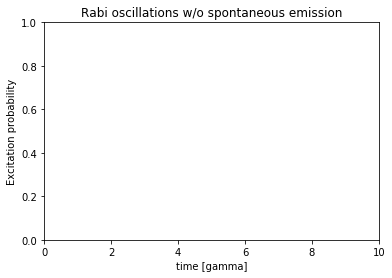

In [7]:
# the free variables for our deriv function
freesyms = flatten([flatten(x) for x in RHS.free_symbols])

# args = (flatten([flatten(x) for x in RHS.free_symbols]),t) #the deriv function args
args = (freesyms,t) #the deriv function args

# generate this derivs function from symbolic Hamiltonian and Lambdify
# TODO: include parameters for H as a tuple
# derivs = lambdify((flatten([flatten(x) for x in RHS.free_symbols]),t),rhs)
derivs = lambdify(args,rhs)
            
t_exp = 10 # experiment duration
ts = np.arange(t_exp,step=dt)

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_ylim((0,1))
ax.set_xlim((0,t_exp))
ax.set_title('Rabi oscillations w/o spontaneous emission')
ax.set_xlabel('time [gamma]')
ax.set_ylabel('Excitation probability')

soln,ctime = odeintz(derivs, r0, ts, args=())
ax.plot(ts,soln[:,1]) # plot rho_ee
plt.show()

TypeError: _lambdifygenerated() takes 2 positional arguments but 6 were given

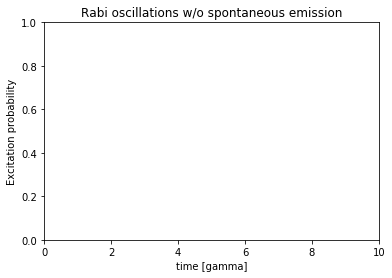

In [10]:
###############################################################################
## Rabi oscillations with no spontaneous emission, for various values
## of detuning from the transition resonance
###############################################################################

# initial conditions - system starts in ground state
rho_ee = 0 + 0j
rho_gg = 1 + 0j
rho_eg = 0 + 0j # no initial mixing; this is actually rho^tilda_ge
y0 = np.array([rho_gg,rho_ee,rho_eg]) # bundle i.c.

# equation parameters
t1 = np.inf # upper state lifetime (1/gamma)
t2 = np.inf # atomic coherence 
D_arr = np.arange(0,4,step=1) # the detuning; run for various values! 
Omega = 1 #1/t1 # treat as real. d*E*exp(-1j*theta) # complex rabi frequency
#params = np.array([Omega,D,t1,t2]) # bundle parameters

# TODO: for param in params: if type(param) = list, iterate over the param
t_exp = 10 # experiment duration
t = np.arange(t_exp,step=dt)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim((0,1))
ax.set_xlim((0,t_exp))
ax.set_title('Rabi oscillations w/o spontaneous emission')
ax.set_xlabel('time [gamma]')
ax.set_ylabel('Excitation probability')

for D in D_arr: # solve and plot for each detuning value 
    func = lambda y,t: derivs(t,y,t1,t2,D,Omega)
    soln = solve_ivp(func,[0,t_exp],y0,t_eval=np.linspace(0,t_exp,50))
    ax.plot(soln.t,soln.y[1],label="Detuning = %s "%D)

ax.legend(loc='upper right')
plt.show()